## Easy Experiment .ipynb File

### <font color='red'><b> 🐬 기억합시다 :] 실험마다 인덱스 붙여서 파일 새로만들기~! <b></font>

## import

In [189]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random
import time
from datetime import timedelta

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_model_summary import summary

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [190]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [191]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [192]:
### cofiguration
seed = 42
check_point_dir_name = 'baseline2'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 500
train_ratio = 0.8
epochs = 20
print_interval = 394
lr = 3e-4
model_name = 'efficientnetv2_rw_m'
num_labels = 18
loss_function_name = 'CrossEntropyLoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
weight_decay = 0.02
scheduler_name = 'CosineAnnealingWarmRestarts'
comment = f'스케줄러 변경'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [193]:
train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
labels = train_df['class'] # input your label feature
stratify_col = train_df['class']

train_paths, valid_paths, train_labels, valid_labels = train_test_split(imgs_path, labels,
                                                                        train_size=train_ratio,
                                                                        shuffle=True,
                                                                        random_state=seed)

In [194]:
os.makedirs(save_dir,exist_ok=True)

In [195]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : lr,
'model_name' : model_name,
'num_labels' : num_labels,
'train_ratio': train_ratio,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'weight_decay' : weight_decay,
'scheduler_name' : scheduler_name,
'comment' : comment
}

In [196]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [197]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy()
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [198]:
train_transforms = A.Compose([
        A.CenterCrop(height=450,width=250),
        A.HorizontalFlip(p=0.5),
        A.Resize(224, 224),
        A.CLAHE(p=1.),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])
    
valid_transforms = A.Compose([
        A.CenterCrop(height=450,width=250),
        A.Resize(224, 224),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])

## make dataset and dataloader

In [199]:
train_dset = CustomTrainDataset(train_paths, train_labels, 'class', train_transforms)
val_dset = CustomTrainDataset(valid_paths, valid_labels, 'class', valid_transforms)

In [200]:
num_of_class = pd.Series(train_labels).value_counts().sort_index().values.tolist()

In [201]:
cls_prob = []
reversed_cls_prob = []

for idx, cnt in enumerate(num_of_class):
    cls_prob.append(cnt/sum(num_of_class))
    # reversed_cls_prob.append((sum(num_of_class)-cnt)/sum(num_of_class))

reversed_cls_prob = [max(cls_prob)/prob for prob in cls_prob]

In [202]:
for idx, prob in enumerate(cls_prob):
    print(idx, prob)

0 0.14556878306878307
1 0.10886243386243387
2 0.022552910052910054
3 0.19358465608465608
4 0.216005291005291
5 0.0289021164021164
6 0.029232804232804232
7 0.02156084656084656
8 0.004298941798941799
9 0.038425925925925926
10 0.043055555555555555
11 0.005621693121693121
12 0.030026455026455026
13 0.02175925925925926
14 0.003902116402116402
15 0.03783068783068783
16 0.04265873015873016
17 0.006150793650793651


In [203]:
for idx, prob in enumerate(reversed_cls_prob):
    print(idx, prob)

0 1.4838709677419355
1 1.9842041312272174
2 9.577712609970675
3 1.1158182439357704
4 1.0
5 7.473684210526316
6 7.389140271493213
7 10.01840490797546
8 50.24615384615385
9 5.621342512908778
10 5.016897081413211
11 38.42352941176471
12 7.1938325991189425
13 9.927051671732523
14 55.355932203389834
15 5.709790209790209
16 5.0635658914728685
17 35.11827956989247


In [204]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [205]:
print(len(train_loader))
print(len(val_loader))

473
8


## visualization transform

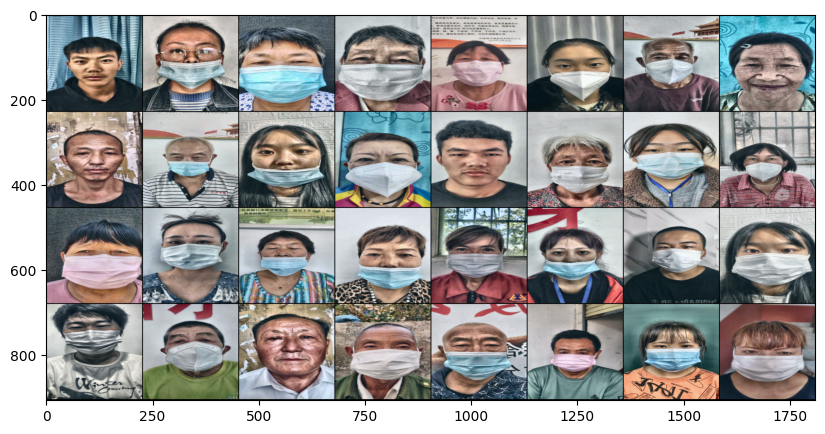

In [206]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

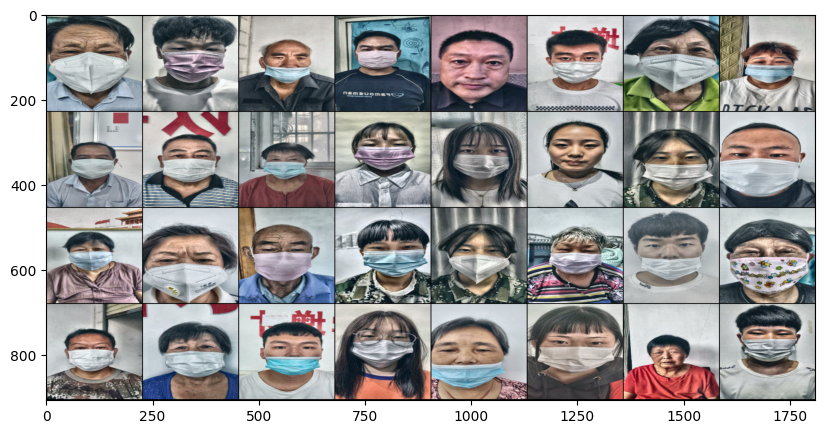

In [207]:
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

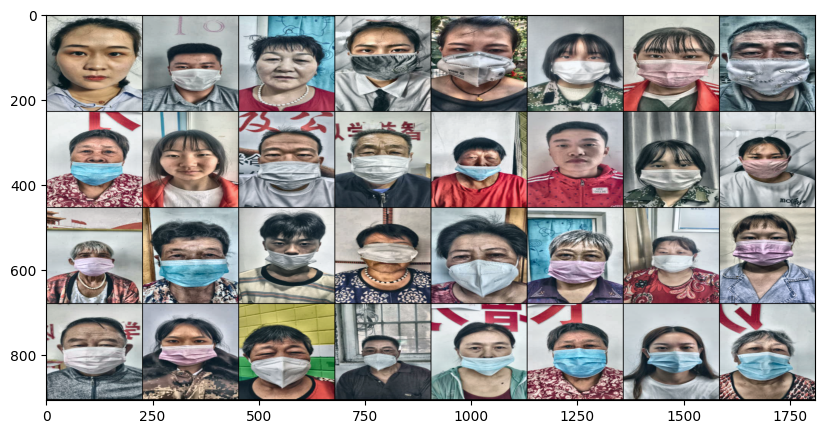

In [208]:
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

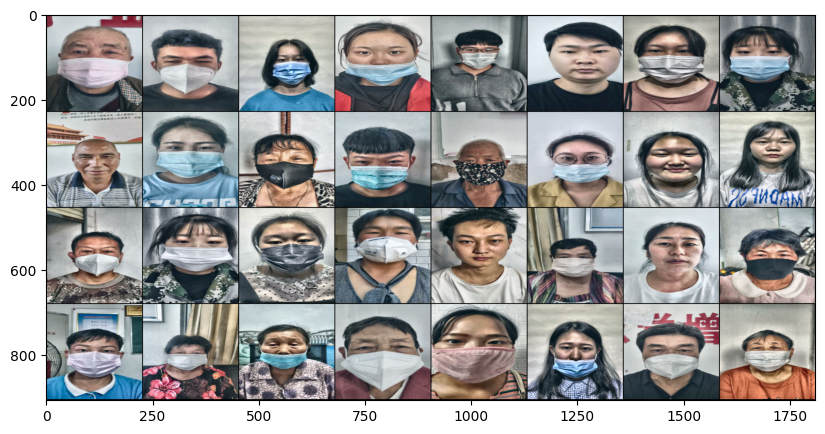

In [209]:
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

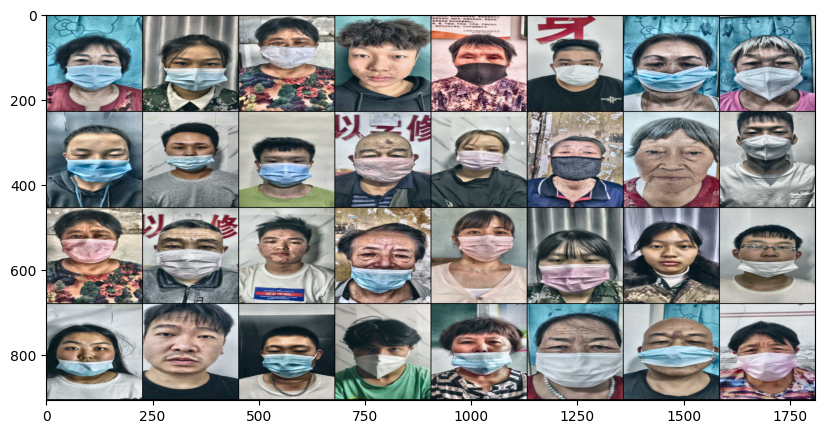

In [210]:
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [211]:
model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_labels)
model.to(device)
# model = torch.nn.DataParallel(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_s

In [212]:
print(summary(model,torch.Tensor(2,3,224,224).to(device)))

---------------------------------------------------------------------------------
              Layer (type)          Output Shape         Param #     Tr. Param #
                  Conv2d-1     [2, 32, 112, 112]             864             864
          BatchNormAct2d-2     [2, 32, 112, 112]              64              64
            EdgeResidual-3     [2, 32, 112, 112]          10,368          10,368
            EdgeResidual-4     [2, 32, 112, 112]          10,368          10,368
            EdgeResidual-5     [2, 32, 112, 112]          10,368          10,368
            EdgeResidual-6       [2, 56, 56, 56]          44,400          44,400
            EdgeResidual-7       [2, 56, 56, 56]         126,000         126,000
            EdgeResidual-8       [2, 56, 56, 56]         126,000         126,000
            EdgeResidual-9       [2, 56, 56, 56]         126,000         126,000
           EdgeResidual-10       [2, 56, 56, 56]         126,000         126,000
           EdgeResidual-11 

## Loss function

In [213]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [214]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
elif loss_function_name == 'FocalLoss':
    criterion = FocalLoss()
elif loss_function_name == 'F1Loss':
    criterion = F1Loss(classes=num_labels)
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

## Optimizer

In [215]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay) # 0.09 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

## Scheduler  

In [216]:
scheduler = None

if scheduler_name == 'ReduceLROnPlateau':
    ## during 5epochs, valid loss decrease 1e-3↓, lr update lr*0.5
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-3) ## 정리
elif scheduler_name == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-4)

assert scheduler != None , 'sheduler is None'

## Train

In [217]:
best_val_acc = 0
best_val_f1 = 0
best_val_loss = np.Inf
best_kappa_val = 0

list_total_preds = [] # for analysis
list_total_labels = [] # for analysis

start=time.process_time()

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, b_labels = train_batch # batch imgs and batch labels
        b_imgs = b_imgs.to(device)
        b_labels = b_labels.to(device)

        b_logits = model(b_imgs)
        b_loss = criterion(b_logits, b_labels)
        b_preds = torch.argmax(b_logits, dim=-1)

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        epoch_loss += b_loss.item()
        epoch_preds += b_preds.detach().cpu().numpy().tolist()
        epoch_labels += b_labels.detach().cpu().numpy().tolist()

        # print interval batch
        if(idx+1) % print_interval == 0:
            current_loss = epoch_loss / (idx+1) # / batch
            correct_list = [i==j for i,j in zip(epoch_preds, epoch_labels)]
            current_acc = sum(correct_list) / len(correct_list)
            custom_sample_weight = [reversed_cls_prob[label] for label in epoch_labels] ## add this line
            epoch_train_f1 = f1_score(epoch_labels, epoch_preds, average='weighted', sample_weight=custom_sample_weight)
            train_kappa = cohen_kappa_score(epoch_labels,epoch_preds)
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss {current_loss:2.4f} || training acc {current_acc:4.2%} || train f1 {epoch_train_f1:2.4f} || "
                    f"lr {optimizer.param_groups[0]['lr']:.5f}"
                )
    
    scheduler.step()
    
    with torch.no_grad():
        print("    Calculating validation results...")
        model.eval()

        val_loss = []
        val_acc = []

        val_preds = [] 
        val_labels = []

        for idx, val_batch in enumerate(val_loader):
            imgs, labels = val_batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            b_loss = criterion(logits, labels).item()
            
            preds = torch.argmax(logits, dim=-1)

            correct_num = (labels == preds).sum().item()

            val_loss.append(b_loss)
            val_acc.append(correct_num)

            val_preds += preds.detach().cpu().numpy().tolist()
            val_labels += labels.detach().cpu().numpy().tolist()

            

        epoch_val_loss =  np.sum(val_loss)/len(val_loader)
        epoch_val_acc = np.sum(val_acc)/len(val_dset)
        custom_sample_weight = [reversed_cls_prob[label] for label in val_labels] ## add this line
        epoch_val_f1 = f1_score(val_labels, val_preds, average='weighted', sample_weight=custom_sample_weight)
        kappa = cohen_kappa_score(val_labels, val_preds)
        best_val_loss = min(best_val_loss, epoch_val_loss)

        if epoch_val_f1 > best_val_f1:
                print(f"  New best model for val f1 : {epoch_val_f1:2.4f}! saving the best model..")
                best_val_f1 = epoch_val_f1
                torch.save(model.state_dict(), f"{save_dir}/best.pth")
                best_kappa_val = kappa
                list_total_preds = val_preds # if best score val-set, assign pred result to list_total_preds
                list_total_labels = val_labels # if best score val-set, assign pred result to list_total_preds
                best_val_acc = epoch_val_acc
                
        torch.save(model.state_dict(), f'{save_dir}/last.pth')
        print(
                f"    [{epoch+1} epoch Val] f1:{epoch_val_f1:2.4f}, loss:{epoch_val_loss:2.4f}, acc:{epoch_val_acc:4.2%} || "
                f"best f1:{best_val_f1:2.4f}, best loss:{best_val_loss:2.4f}, best state acc:{best_val_acc:4.2%}"
            )
        print(f"    Generalization gap => f1 : {epoch_train_f1-best_val_f1:2.4f}, current loss : {current_loss-epoch_val_loss:2.4f}")
    print()
end = time.process_time()

Epoch[1/20](394/473) || training loss 0.4520 || training acc 85.58% || train f1 0.6942 || lr 0.00030
    Calculating validation results...
  New best model for val f1 : 0.8833! saving the best model..
    [1 epoch Val] f1:0.8833, loss:0.1761, acc:93.57% || best f1:0.8833, best loss:0.1761, best state acc:93.57%
    Generalization gap => f1 : -0.1891, current loss : 0.2760

Epoch[2/20](394/473) || training loss 0.0967 || training acc 96.85% || train f1 0.9333 || lr 0.00028
    Calculating validation results...
  New best model for val f1 : 0.8918! saving the best model..
    [2 epoch Val] f1:0.8918, loss:0.1861, acc:94.44% || best f1:0.8918, best loss:0.1761, best state acc:94.44%
    Generalization gap => f1 : 0.0415, current loss : -0.0894

Epoch[3/20](394/473) || training loss 0.0462 || training acc 98.47% || train f1 0.9680 || lr 0.00023
    Calculating validation results...
  New best model for val f1 : 0.9371! saving the best model..
    [3 epoch Val] f1:0.9371, loss:0.0938, acc:9

```
normal f1
Epoch[20/20](394/473) || training loss 0.0040 || training acc 99.89% || train f1 0.9987 || lr 0.00012
    Calculating validation results...
  New best model for val f1 : 0.9937! saving the best model..
    [20 epoch Val] f1:0.9937, loss:0.0222, acc:99.55% || best f1:0.9937, best loss:0.0222, best state acc:99.55%
    Generalization gap => f1 : 0.0050, current loss : -0.0181
```

```
weighted f1
Epoch[20/20](394/473) || training loss 0.0040 || training acc 99.89% || train f1 0.9988 || lr 0.00012
    Calculating validation results...
  New best model for val f1 : 0.9929! saving the best model..
    [20 epoch Val] f1:0.9929, loss:0.0222, acc:99.55% || best f1:0.9929, best loss:0.0222, best state acc:99.55%
    Generalization gap => f1 : 0.0059, current loss : -0.0181
```

```
use weighted f1 score ← may be worse than normal f1 ← right but small effect
```

In [218]:
print("Time elapsed: ", timedelta(seconds=end-start))

Time elapsed:  1:19:07.404452


## Error Analysis

In [219]:
df_diff = pd.DataFrame()
df_diff['labels'] = list_total_labels
df_diff['preds'] = list_total_preds
df_diff.to_csv(f'{save_dir}/diff.csv')

In [220]:
## label to sentence
def get_sentence(code):
    codebook = ['Wear,male,junior', # 0
                'Wear,male,middle', # 1
                'Wear,male,senior', # 2
                'Wear,female,junior', # 3
                'Wear,female,middle', # 4
                'Wear,female,senior', # 5
                'Incorrect,male,junior', # 6
                'Incorrect,male,middle', # 7
                'Incorrect,male,senior', # 8
                'Incorrect,female,junior', # 9
                'Incorrect,female,middle', # 10
                'Incorrect,female,senior', # 11
                'Not Wear,male,junior', # 12
                'Not Wear,male,middle', # 13
                'Not Wear,male,senior', # 14
                'Not Wear,female,junior', # 15
                'Not Wear,female,middle', # 16
                'Not Wear,female,senior'] # 17
    return codebook[code]

# age to sentence
def get_age_category(num):
    category = None
    if num>=60:
        category = 'senior'
    elif 30<=num<60:
        category = 'middle'
    else:
        category = 'junior'
    return category

In [221]:
list_wear_labels = []
list_gender_labels = []
list_age_labels = []

list_wear_preds = []
list_gender_preds = []
list_age_preds = []

for label in df_diff['labels']:
    row = get_sentence(label).split(',')
    list_wear_labels.append(row[0])
    list_gender_labels.append(row[1])
    list_age_labels.append(row[2])

for label in df_diff['preds']:
    row = get_sentence(label).split(',')
    list_wear_preds.append(row[0])
    list_gender_preds.append(row[1])
    list_age_preds.append(row[2])

In [222]:
list_cause = []
for row in zip(list_wear_labels, list_wear_preds, list_gender_labels, list_gender_preds, list_age_labels, list_age_preds):
    sentence = []
    if row[0] != row[1]:
        sentence.append(f'mask   : {row[0]} → {row[1]}')
    if row[2] != row[3]:
        sentence.append(f'gender : {row[2]} → {row[3]}')
    if row[4] != row[5]:
        sentence.append(f'age    : {row[4]} → {row[5]}')
    
    if len(sentence) == 0:
        sentence = "all correct"
    elif len(sentence) == 1:
        sentence = sentence[0]
    else: # len(sentence) == 2
        sentence = ','.join(sentence)
    list_cause.append(sentence)

In [225]:
l = pd.Series(list_cause)
l.value_counts().sort_values(ascending = False)

all correct                      3763
mask   : Incorrect → Wear           6
age    : middle → junior            6
age    : middle → senior            2
gender : male → female              1
mask   : Incorrect → Not Wear       1
mask   : Not Wear → Incorrect       1
dtype: int64

```
normal f1 checkpoint
all correct                      3763
mask   : Incorrect → Wear           6
age    : middle → junior            6
age    : middle → senior            2
gender : male → female              1
mask   : Incorrect → Not Wear       1
mask   : Not Wear → Incorrect       1
dtype: int64
```

```
weighted f1 score # this case will be the good than normal f1 checkpoint
```

```
all correct                      3763
mask   : Incorrect → Wear           6
age    : middle → junior            6
age    : middle → senior            2
gender : male → female              1
mask   : Incorrect → Not Wear       1
mask   : Not Wear → Incorrect       1
dtype: int64
```

why test f1_score is so lower than valid f1_score?

In [224]:
df_diff['cause'] = list_cause
df_diff.to_csv(f'{save_dir}/analysis.csv')

## inference

## inference config

In [ ]:
model_name = 'efficientnetv2_rw_m'
check_point_dir_name = 'baseline2'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 500
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [ ]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=num_labels)
model.to(device)
model.load_state_dict(torch.load(save_file_path))
model = torch.nn.DataParallel(model)

## test dataset

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_transforms = A.Compose([A.Resize(224, 224),
                             A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
                             ToTensorV2()])

In [ ]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [ ]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [ ]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [ ]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")